In [33]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile

In [10]:
from IPython.display import Image, display

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [35]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions
from tensorflow.keras import layers, models, optimizers

In [16]:
masks_zip = 'archive.zip'

In [17]:
base_dir = '/home/mr_wick/Documents/mask_detection/data/'

extract data

In [19]:
with zipfile.ZipFile(masks_zip) as my_zip:
    my_zip.extractall(base_dir)

Retrieve data from each directory

In [20]:
with_mask = os.path.join(base_dir, 'Dataset/with_mask')
print(f'There are {len(os.listdir(with_mask))} images with masks')

There are 2994 images with masks


In [21]:
without_mask = os.path.join(base_dir, 'Dataset/without_mask')
print(f'There are {len(os.listdir(with_mask))} images without masks')

There are 2994 images without masks


In [22]:
mask_weared_incorrect = os.path.join(base_dir, 'Dataset/mask_weared_incorrect')
print(f'There are {len(os.listdir(with_mask))} images of masks worn incorrectly')

There are 2994 images of masks worn incorrectly


Display an image from each directory for different classes we are trying to predict

Sample with Mask On


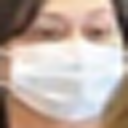

Sample Without Mask On


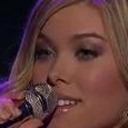

Sample With Mask Worn Incorrectly


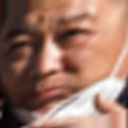

In [23]:
print("Sample with Mask On")
display(Image(filename=f'{os.path.join(with_mask, os.listdir(with_mask)[2])}'))

print('Sample Without Mask On')
display(Image(filename=f'{os.path.join(without_mask, os.listdir(without_mask)[0])}'))

print('Sample With Mask Worn Incorrectly')
display(Image(filename=f'{os.path.join(mask_weared_incorrect, os.listdir(mask_weared_incorrect)[1])}'))


# Train, Evaluation, Test Splits

In [139]:
train_eval_test_dirs = ['train/masks', 'train/without_masks', 'train/masks_incorrectly',
                       'eval/masks', 'eval/without_masks', 'eval/masks_incorrectly',
                       'test/masks', 'test/without_masks', 'test/masks_incorrectly']

In [140]:
for dir in train_eval_test_dirs:
    if not os.path.exists(os.path.join(base_dir, dir)):
        os.makedirs(os.path.join(base_dir, dir))

In [141]:
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

Move 50% of all images into train_directories

In [142]:
move_to_destination(with_mask, os.path.join(base_dir, 'train/masks'), 0.5)
move_to_destination(without_mask, os.path.join(base_dir, 'train/without_masks'), 0.5)
move_to_destination(mask_weared_incorrect, os.path.join(base_dir, 'train/masks_incorrectly'), 0.5)

In [24]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/masks')))} images of masks for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/without_masks')))} images without masks for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/masks_incorrectly')))} images of masks worn incorrectly for training\n")

There are 1497 images of masks for training
There are 1497 images without masks for training
There are 1497 images of masks worn incorrectly for training



Move 25% of all images into evaluation directories

In [144]:
move_to_destination(with_mask, os.path.join(base_dir, 'eval/masks'), .75)
move_to_destination(without_mask, os.path.join(base_dir, 'eval/without_masks'), .75)
move_to_destination(mask_weared_incorrect, os.path.join(base_dir, 'eval/masks_incorrectly'), .75)

In [25]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/masks')))} images of masks for evalutation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/without_masks')))} images without masks for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/masks_incorrectly')))} images of masks worn incorrectly for evaluation\n")

There are 1122 images of masks for evalutation
There are 1122 images without masks for evaluation
There are 1122 images of masks worn incorrectly for evaluation



Move 25% of all images into test directories

In [146]:
move_to_destination(with_mask, os.path.join(base_dir, 'test/masks'), 1)
move_to_destination(without_mask, os.path.join(base_dir, 'test/without_masks'), 1)
move_to_destination(mask_weared_incorrect, os.path.join(base_dir, 'test/masks_incorrectly'), 1)

In [26]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'test/masks')))} images of masks for testing")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'test/without_masks')))} images without masks for testing")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'test/masks_incorrectly')))} images of masks worn incorrectly for testing\n")

There are 375 images of masks for testing
There are 375 images without masks for testing
There are 375 images of masks worn incorrectly for testing



# Build Model with Data Augmentation

Since our test set has limited data, we will augment this data to create more data for training.

In [10]:
def model():
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [11]:
augmented_model = model()

In [12]:
augmented_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

# Train and Validation Generators

In [27]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=50,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True)

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
'/home/mr_wick/Documents/mask_detection/data/train',
target_size=(150, 150),
batch_size=32,
class_mode='binary')

Found 4491 images belonging to 3 classes.


In [30]:
validation_generator = test_datagen.flow_from_directory(
'/home/mr_wick/Documents/mask_detection/data/eval',
target_size=(150, 150),
batch_size=32,
class_mode='binary')

Found 3366 images belonging to 3 classes.


In [155]:
augmented_history = augmented_model.fit(
train_generator, 
steps_per_epoch=100,
epochs=80,
validation_data=validation_generator,
validation_steps=80)

Epoch 1/80
100/100 [==============================] - 14s 130ms/step - loss: 0.6051 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.3655 - val_sparse_categorical_accuracy: 0.8520
Epoch 2/80
100/100 [==============================] - 13s 129ms/step - loss: 0.4826 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.3702 - val_sparse_categorical_accuracy: 0.8621
Epoch 3/80
100/100 [==============================] - 13s 128ms/step - loss: 0.4343 - sparse_categorical_accuracy: 0.8253 - val_loss: 0.3095 - val_sparse_categorical_accuracy: 0.8754
Epoch 4/80
100/100 [==============================] - 13s 127ms/step - loss: 0.4137 - sparse_categorical_accuracy: 0.8405 - val_loss: 0.2779 - val_sparse_categorical_accuracy: 0.8906
Epoch 5/80
100/100 [==============================] - 13s 127ms/step - loss: 0.4016 - sparse_categorical_accuracy: 0.8405 - val_loss: 0.3280 - val_sparse_categorical_accuracy: 0.8664
Epoch 6/80
100/100 [==============================] - 13s 126ms/step - loss: 0.3319 -

In [17]:
def training_metrics(history):
    if not isinstance(history, pd.core.frame.DataFrame):
        history = history.history
        
    acc = history['sparse_categorical_accuracy']
    val_acc = history['val_sparse_categorical_accuracy']
    
    loss = history['loss']
    val_loss = history['val_loss']
    
    return acc, val_acc, loss, val_loss

In [18]:
def plot_train_eval(history):
    acc, val_acc, loss, val_loss = training_metrics(history)
    
    acc_plot = pd.DataFrame({'training accuracy':acc, 'evaluation accuracy': val_acc})
    acc_plot = sns.lineplot(data=acc_plot)
    acc_plot.set_title("Training vs Evaluation Accuracy")
    acc_plot.set_xlabel('Epoch')
    acc_plot.set_ylabel('Sparse Categorical Accuracy')
    
    loss_plot = pd.DataFrame({'training loss': loss, 'evaluation loss':val_loss})
    loss_plot = sns.lineplot(data=loss_plot)
    loss_plot.set_title('Training vs Evaluation Loss')
    loss_plot.set_xlabel('Epoch')
    loss_plot.set_ylabel('Loss')
    plt.show()

In [19]:
tf.keras.models.save_model(augmented_model, 'augmented_masks')

INFO:tensorflow:Assets written to: augmented_masks/assets


In [26]:
def model_2():
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [27]:
augmented_model_2 = model_2()

In [28]:
augmented_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [175]:
augmented_history = augmented_model_2.fit(
train_generator, 
steps_per_epoch=100,
epochs=50,
validation_data=validation_generator,
validation_steps=80)

Epoch 1/50
100/100 [==============================] - 13s 131ms/step - loss: 0.6637 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.4235 - val_sparse_categorical_accuracy: 0.8410
Epoch 2/50
100/100 [==============================] - 13s 133ms/step - loss: 0.4825 - sparse_categorical_accuracy: 0.8028 - val_loss: 0.3588 - val_sparse_categorical_accuracy: 0.8629
Epoch 3/50
100/100 [==============================] - 13s 128ms/step - loss: 0.4102 - sparse_categorical_accuracy: 0.8327 - val_loss: 0.3643 - val_sparse_categorical_accuracy: 0.8598
Epoch 4/50
100/100 [==============================] - 13s 130ms/step - loss: 0.4560 - sparse_categorical_accuracy: 0.8201 - val_loss: 0.4451 - val_sparse_categorical_accuracy: 0.8465
Epoch 5/50
100/100 [==============================] - 13s 127ms/step - loss: 0.4410 - sparse_categorical_accuracy: 0.8231 - val_loss: 0.4090 - val_sparse_categorical_accuracy: 0.8418
Epoch 6/50
100/100 [==============================] - 13s 127ms/step - loss: 0.4133 -

In [62]:
tf.keras.models.save_model(augmented_model_2, 'augmented_masks_2')

INFO:tensorflow:Assets written to: augmented_masks_2/assets


In [65]:
tf.keras.models.load_model('augmented_masks_2')

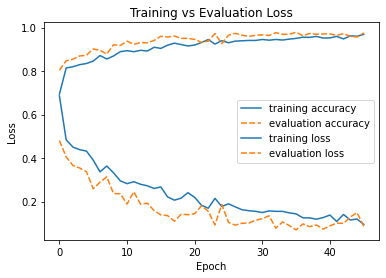

In [66]:
plot_train_eval(augmented_history)

# Model 3 with CallBacks

In [42]:
def model_3():
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [43]:
augmented_model_3 = model_3()

In [44]:
#augmented_model.summary()

In [45]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='augmented_model_3.h5',
        monitor='val_loss',
        save_best_only=True,    
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='my_logs',
        histogram_freq=1,
        #embeddings=_freq=1,
    )  
]

In [46]:
augmented_history_2 = augmented_model_3.fit(
train_generator, 
steps_per_epoch=100,
epochs=80,
callbacks=callbacks_list,
validation_data=validation_generator,
validation_steps=80)

Epoch 1/80
100/100 [==============================] - 13s 127ms/step - loss: 0.7087 - sparse_categorical_accuracy: 0.6738 - val_loss: 0.4948 - val_sparse_categorical_accuracy: 0.8090
Epoch 2/80
100/100 [==============================] - 12s 125ms/step - loss: 0.5137 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.4185 - val_sparse_categorical_accuracy: 0.8609
Epoch 3/80
100/100 [==============================] - 12s 124ms/step - loss: 0.4694 - sparse_categorical_accuracy: 0.8166 - val_loss: 0.3628 - val_sparse_categorical_accuracy: 0.8574
Epoch 4/80
100/100 [==============================] - 13s 126ms/step - loss: 0.4241 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.4157 - val_sparse_categorical_accuracy: 0.8609
Epoch 5/80
100/100 [==============================] - 12s 125ms/step - loss: 0.4225 - sparse_categorical_accuracy: 0.8356 - val_loss: 0.3340 - val_sparse_categorical_accuracy: 0.8723
Epoch 6/80
100/100 [==============================] - 13s 128ms/step - loss: 0.3996 -

# Run Tests on the Data to evaluate performance of our model

In [57]:
#Run validation generator without shuffle
val_gen_no_shuffle = test_datagen.flow_from_directory(
'/home/mr_wick/Documents/mask_detection/data/eval',
target_size=(150, 150),
batch_size=32,
class_mode='binary',
shuffle=False)

Found 3366 images belonging to 3 classes.


In [58]:
#Retrieve true labels from the generators
y_true = val_gen_no_shuffle.classes

In [59]:
y_true.shape

(3366,)

In [60]:
#Predict using model 1
augmented_predictions = augmented_model_3.predict(val_gen_no_shuffle)

In [61]:
#Get argmax as softmax is being used in Dense layer
y_pred_augmented = np.argmax(augmented_predictions, axis=1)

In [62]:
#Get accuracy score
print(f'Accuracy Score: {accuracy_score(y_true, y_pred_augmented)}')

#Get balanced accuracy score
print(f'Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_augmented)}')

Accuracy Score: 0.9646464646464646
Balanced Accuracy Score: 0.9646464646464646


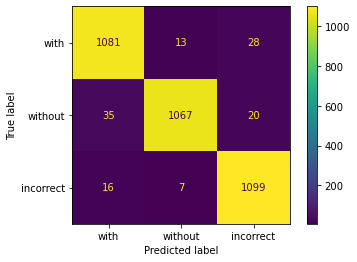

In [63]:
imbalanced_cm = confusion_matrix(y_true, y_pred_augmented)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['with', 'without', 'incorrect']).plot(values_format="d")

# Test Model with Test Dataset

In [64]:
model = tf.keras.models.load_model('augmented_model_3.h5')

In [65]:
test_generator = test_datagen.flow_from_directory(
'/home/mr_wick/Documents/mask_detection/data/test',
target_size=(150, 150),
batch_size=32,
class_mode='binary')

Found 1125 images belonging to 3 classes.


In [66]:
test_loss, test_acc = model.evaluate(test_generator, steps=32)
print('test_acc', round(test_acc, 4))

32/32 [==============================] - 1s 23ms/step - loss: 0.1006 - sparse_categorical_accuracy: 0.9619
test_acc 0.9619


# Test with your own photos

In [69]:
from tensorflow.keras.preprocessing import image

In [91]:
img_path = '/home/mr_wick/Documents/mask_detection/images/mask.jpg'

In [92]:
img = image.load_img(img_path, target_size=(150, 150))

In [93]:
x = image.img_to_array(img)

In [94]:
x = np.expand_dims(x, axis=0)

In [95]:
x = preprocess_input(x)

In [96]:
preds = model.predict(x)

In [97]:
print(preds)

[[1. 0. 0.]]


In [191]:
def preprocess_image(image):
    # make image into numpy array
    image = img_to_array(image)

    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    return image

In [192]:
def prediction(image):
    # predict the probability across all output classes
    predict = model.predict(image)

    # convert the probabilities to class labels
    label = decode_predictions(predict)

    # retrieve the most likely probability 
    label = label[0][0]

    # return the classification
    prediction = label[1]
    print('%s (%.2f%%)' % (label[1], label[2]*100))

    return prediction

In [193]:
image = load_img('images/without_mask.jpg', target_size=(150, 150))
image = preprocess_image(image)
#prediction = prediction(image)
#print(prediction)

In [99]:
#print(image)

In [195]:
image.shape

(1, 150, 150, 3)

In [196]:
predict = model.predict(image)

In [199]:
print(predict)

[[1. 0. 0.]]


In [200]:
predict.shape

(1, 3)